<a href="https://colab.research.google.com/github/MPGarg/Assignment-8/blob/main/EVA8_Assigment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import files from GIT Hub

In [ ]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 85 (delta 14), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (85/85), 32.05 KiB | 482.00 KiB/s, done.


# Custom ResNet class is imported

In [ ]:
from main_repo.models import custom_resnet
from main_repo.models.custom_resnet import Custom_ResNet

# Import Other fuctions

In [ ]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
view_model = Custom_ResNet().to(device)
summary(view_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Show sample images and Load dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


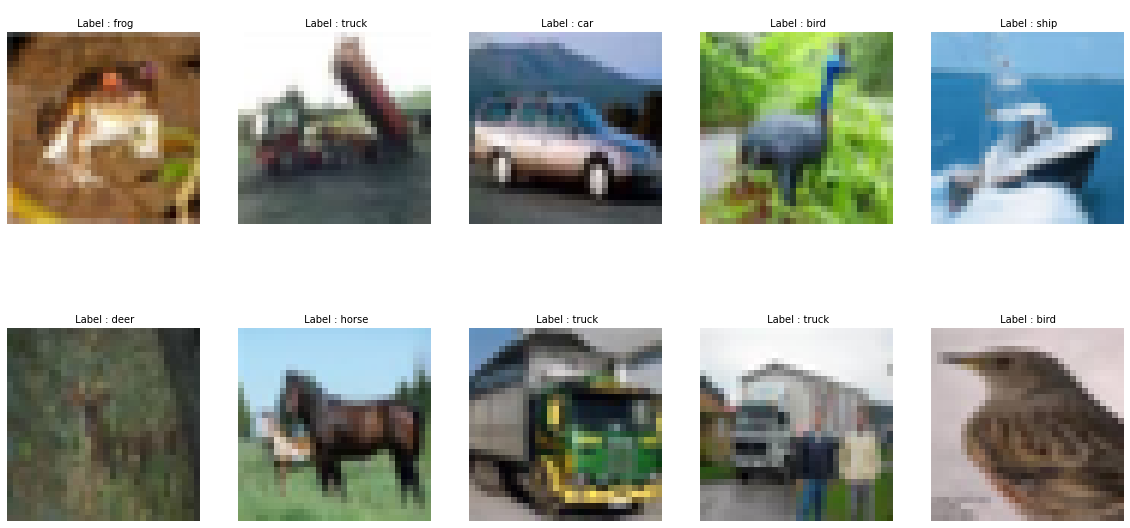

In [ ]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std = process_dataset(visualize = 'X')     

# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-01


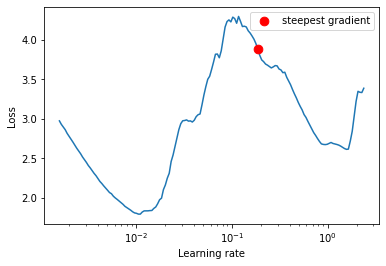

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7a57e77c10>, 0.1867913599020783)

In [ ]:
import copy
model = Custom_ResNet().to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9,weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_mod, end_lr=10, num_iter=200)
lr_finder.plot() 

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.011097524964120722


# Train & Test Model

In [ ]:
#model = Custom_ResNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9,weight_decay=0.005)
#max_lr is the maximum learning rate of OneCycleLR 
#the learning rate will increase from max_lr / div_factor to max_lr in the first pct_start * total_steps steps, 
#and decrease smoothly to max_lr / final_div_factor then.
#total_steps = epochs * steps_per_epoch
#total_steps = 24 * 98 = 2,352
#max_lr / div_factor = 0.01 / 10 = 0.001
#pct_start * total_steps = 0.002 * 2,352 = 4.704
#max_lr / final_div_factor = 0.01 / 100 = 0.00001
#final_div_factor (float) – Determines the minimum learning rate via min_lr = initial_lr/final_div_factor

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.0011097524964120721)


100%|██████████| 98/98 [00:27<00:00,  3.51it/s]


Average Training Loss=0.0032812762451171875, Accuracy=41.334


Test set: Average loss: 0.0024, Accuracy: 5633/10000 (56.33%)

EPOCH: 2 (LR: 0.003194971290266882)


100%|██████████| 98/98 [00:27<00:00,  3.53it/s]


Average Training Loss=0.002032338491678238, Accuracy=63.084


Test set: Average loss: 0.0020, Accuracy: 6602/10000 (66.02%)

EPOCH: 3 (LR: 0.005280190084121692)


100%|██████████| 98/98 [00:27<00:00,  3.61it/s]


Average Training Loss=0.001566891303062439, Accuracy=71.914


Test set: Average loss: 0.0016, Accuracy: 7216/10000 (72.16%)

EPOCH: 4 (LR: 0.007365408877976501)


100%|██████████| 98/98 [00:27<00:00,  3.55it/s]


Average Training Loss=0.0013158979070186615, Accuracy=76.436


Test set: Average loss: 0.0013, Accuracy: 7705/10000 (77.05%)

EPOCH: 5 (LR: 0.00945062767183131)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.001126662505865097, Accuracy=80.012


Test set: Average loss: 0.0012, Accuracy: 7935/10000 (79.35%)

EPOCH: 6 (LR: 0.01097602904141093)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.0009631407660245895, Accuracy=83.012


Test set: Average loss: 0.0013, Accuracy: 7839/10000 (78.39%)

EPOCH: 7 (LR: 0.010398038729490562)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.000820088946223259, Accuracy=85.578


Test set: Average loss: 0.0010, Accuracy: 8194/10000 (81.94%)

EPOCH: 8 (LR: 0.009820048417570192)


100%|██████████| 98/98 [00:27<00:00,  3.51it/s]


Average Training Loss=0.0007122552013397217, Accuracy=87.506


Test set: Average loss: 0.0010, Accuracy: 8358/10000 (83.58%)

EPOCH: 9 (LR: 0.009242058105649823)


100%|██████████| 98/98 [00:27<00:00,  3.52it/s]


Average Training Loss=0.0006487267398834228, Accuracy=88.614


Test set: Average loss: 0.0008, Accuracy: 8568/10000 (85.68%)

EPOCH: 10 (LR: 0.008664067793729455)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.0005698258477449417, Accuracy=90.022


Test set: Average loss: 0.0008, Accuracy: 8599/10000 (85.99%)

EPOCH: 11 (LR: 0.008086077481809086)


100%|██████████| 98/98 [00:27<00:00,  3.59it/s]


Average Training Loss=0.0005000453937053681, Accuracy=91.318


Test set: Average loss: 0.0010, Accuracy: 8364/10000 (83.64%)

EPOCH: 12 (LR: 0.007508087169888718)


100%|██████████| 98/98 [00:27<00:00,  3.59it/s]


Average Training Loss=0.0004630700492858887, Accuracy=91.954


Test set: Average loss: 0.0008, Accuracy: 8651/10000 (86.51%)

EPOCH: 13 (LR: 0.0069300968579683484)


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Average Training Loss=0.0004038396918773651, Accuracy=93.228


Test set: Average loss: 0.0007, Accuracy: 8751/10000 (87.51%)

EPOCH: 14 (LR: 0.00635210654604798)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.0003646432790160179, Accuracy=93.872


Test set: Average loss: 0.0008, Accuracy: 8638/10000 (86.38%)

EPOCH: 15 (LR: 0.0057741162341276115)


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Average Training Loss=0.00032800471276044844, Accuracy=94.616


Test set: Average loss: 0.0007, Accuracy: 8797/10000 (87.97%)

EPOCH: 16 (LR: 0.005196125922207242)


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Average Training Loss=0.000293176983743906, Accuracy=95.288


Test set: Average loss: 0.0007, Accuracy: 8812/10000 (88.12%)

EPOCH: 17 (LR: 0.004618135610286873)


100%|██████████| 98/98 [00:27<00:00,  3.52it/s]


Average Training Loss=0.000270735140889883, Accuracy=95.714


Test set: Average loss: 0.0008, Accuracy: 8728/10000 (87.28%)

EPOCH: 18 (LR: 0.0040401452983665044)


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Average Training Loss=0.00024138215601444244, Accuracy=96.254


Test set: Average loss: 0.0007, Accuracy: 8818/10000 (88.18%)

EPOCH: 19 (LR: 0.003462154986446136)


100%|██████████| 98/98 [00:27<00:00,  3.55it/s]


Average Training Loss=0.00021520620673894884, Accuracy=96.678


Test set: Average loss: 0.0006, Accuracy: 8940/10000 (89.40%)

EPOCH: 20 (LR: 0.0028841646745257667)


100%|██████████| 98/98 [00:27<00:00,  3.56it/s]


Average Training Loss=0.00019690462335944175, Accuracy=97.054


Test set: Average loss: 0.0007, Accuracy: 8872/10000 (88.72%)

EPOCH: 21 (LR: 0.002306174362605398)


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Average Training Loss=0.00017330116122961045, Accuracy=97.582


Test set: Average loss: 0.0006, Accuracy: 9006/10000 (90.06%)

EPOCH: 22 (LR: 0.0017281840506850298)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.00014713398441672324, Accuracy=98.028


Test set: Average loss: 0.0006, Accuracy: 9009/10000 (90.09%)

EPOCH: 23 (LR: 0.0011501937387646596)


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Average Training Loss=0.00012976432606577872, Accuracy=98.32


Test set: Average loss: 0.0006, Accuracy: 9058/10000 (90.58%)

EPOCH: 24 (LR: 0.0005722034268442928)


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Average Training Loss=0.00011786361031234265, Accuracy=98.562


Test set: Average loss: 0.0006, Accuracy: 9069/10000 (90.69%)

Total Number of incorrectly predicted images by model is 931


# Display Validation Accuracy & Loss

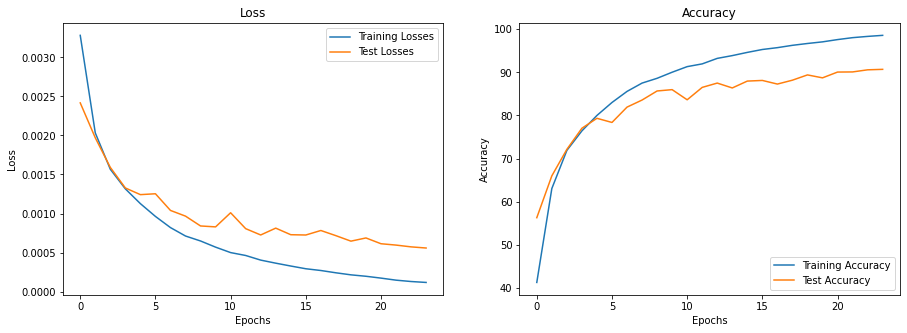

In [ ]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

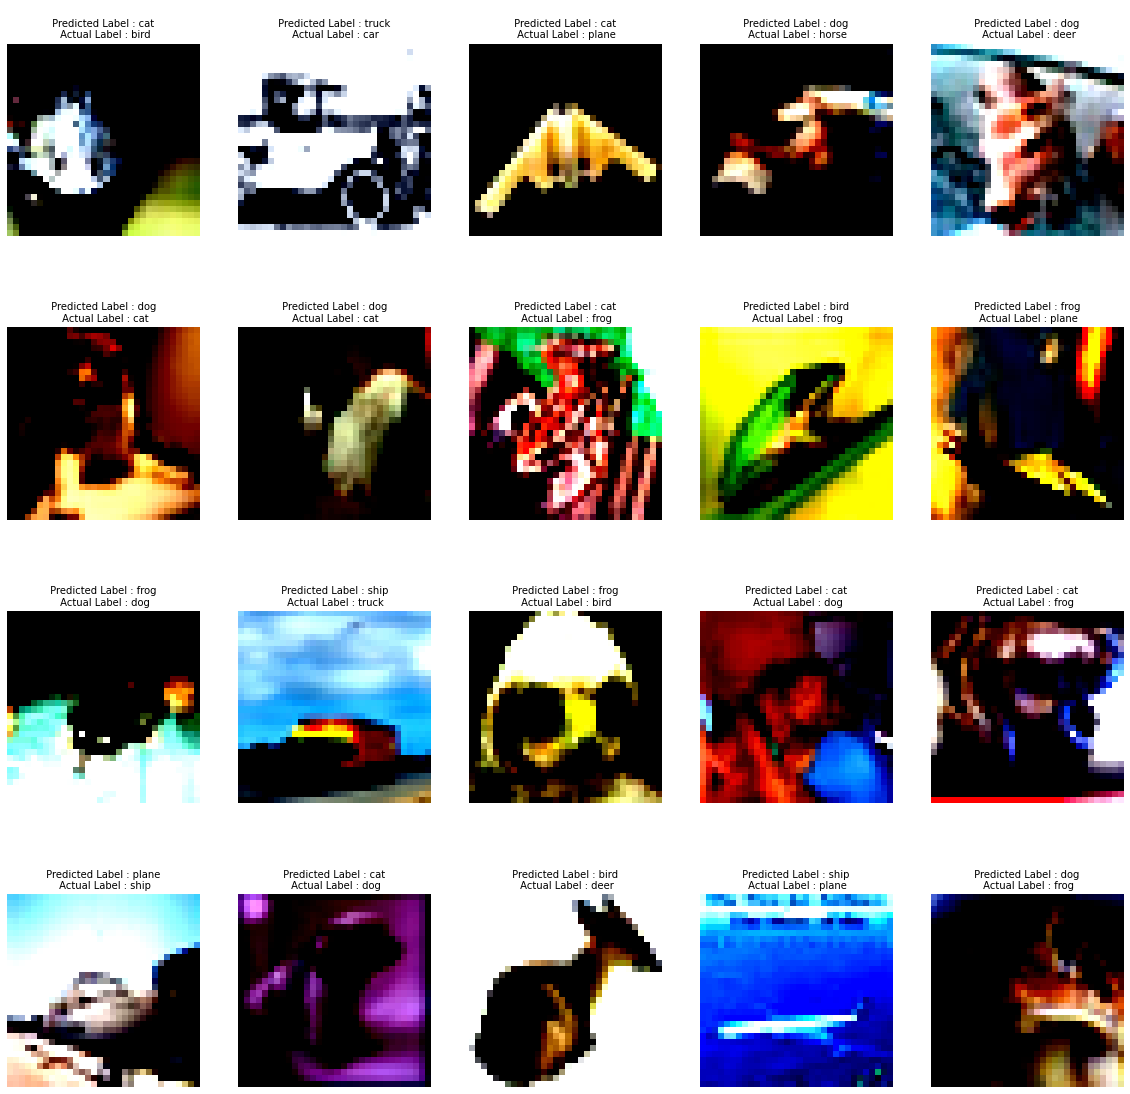

In [ ]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [ ]:
target_layers = ["layer1", "layer2","layer3"]
torch.autograd.set_detect_anomaly(True)

In [ ]:
from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


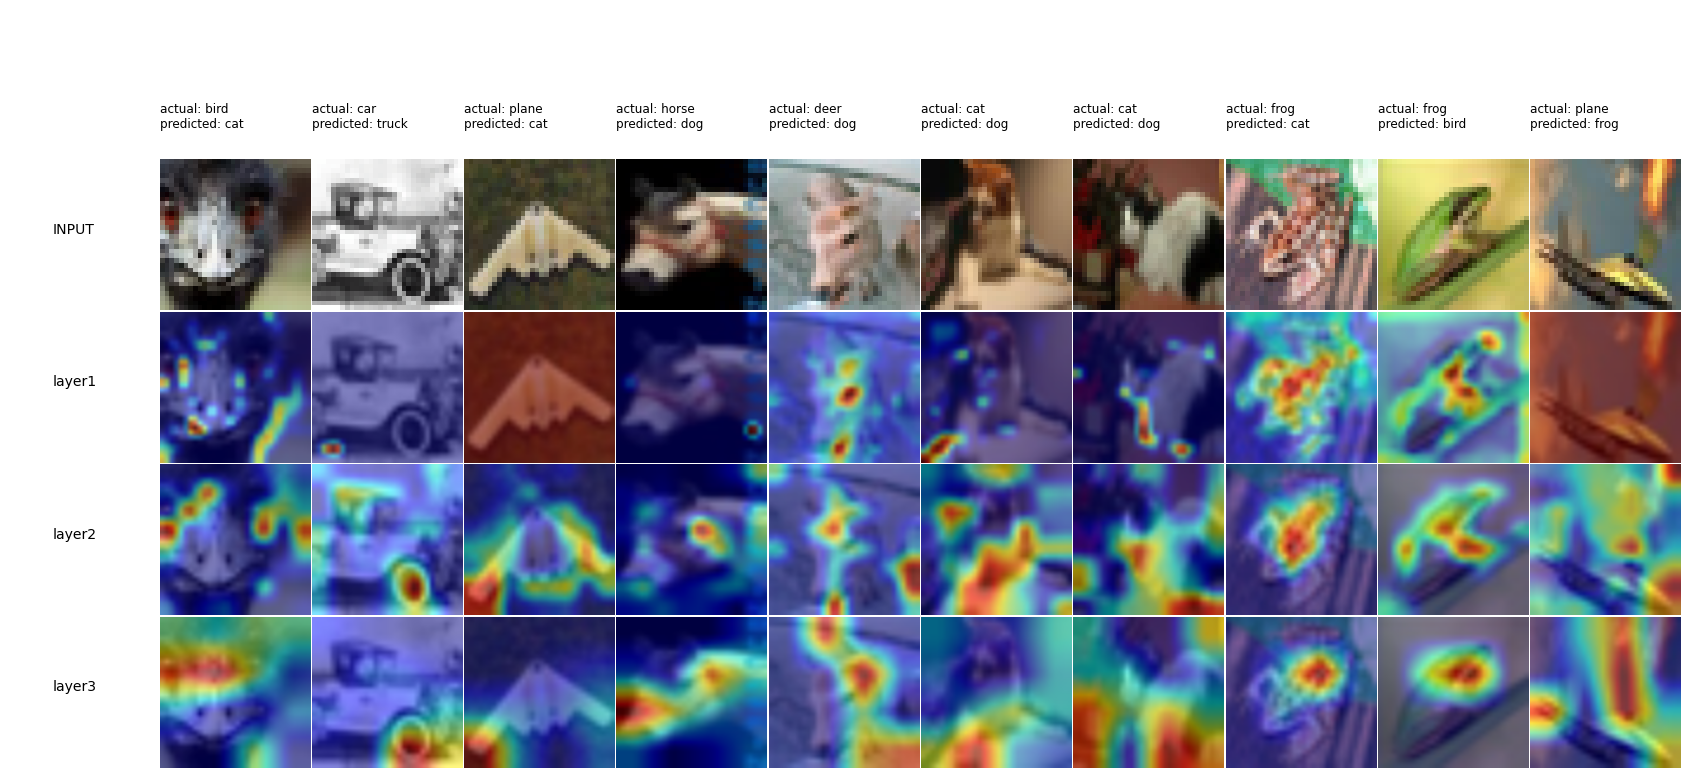

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [ ]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


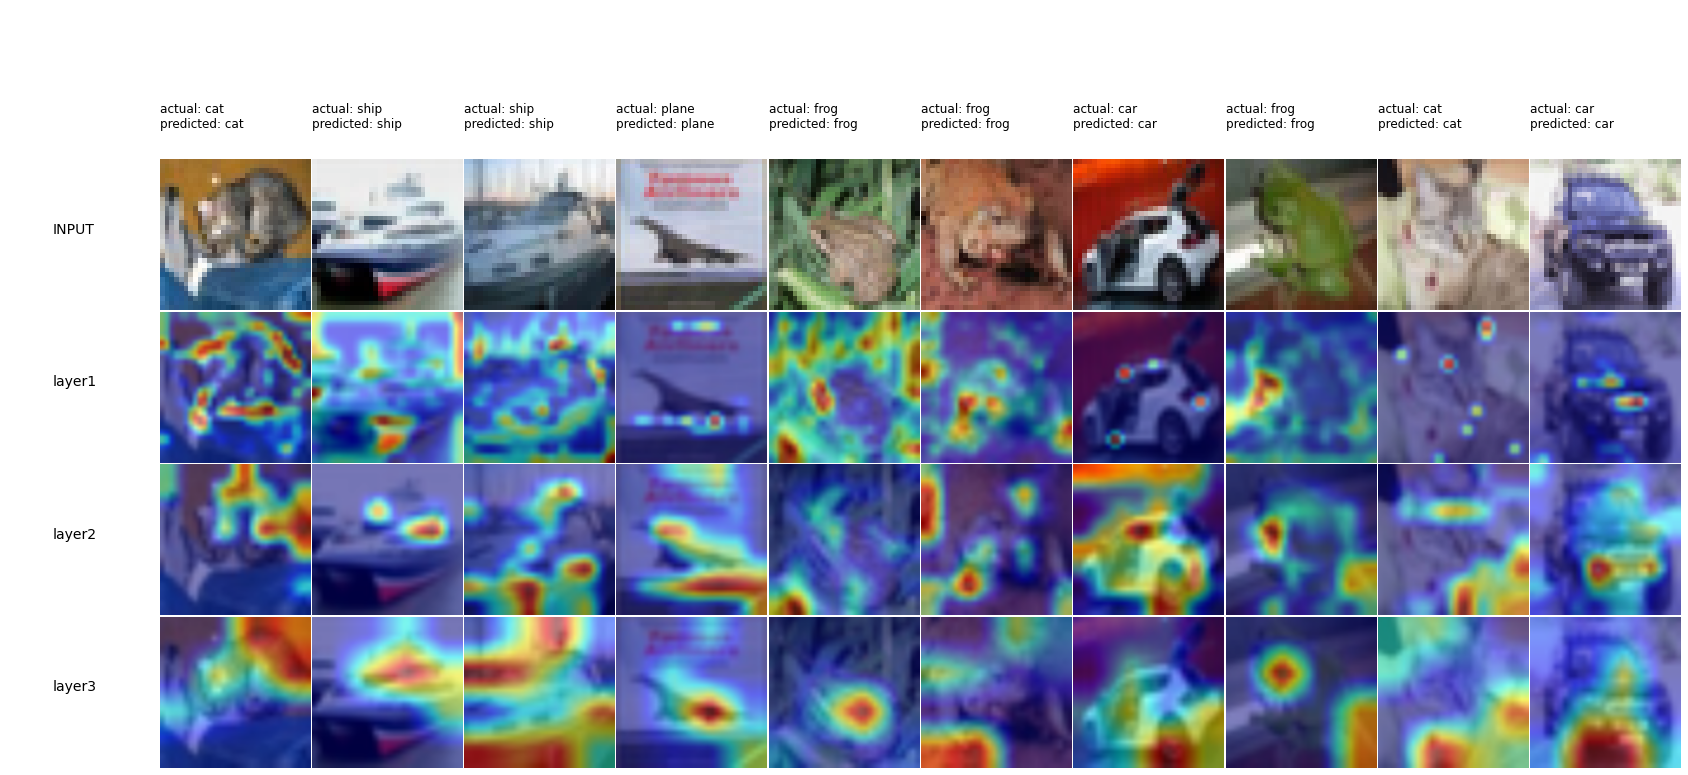

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)